In [ ]:
from notebooks import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The potoo.default_magic_magic extension is already loaded. To reload it, use:
  %reload_ext potoo.default_magic_magic


In [ ]:
# Load models
load = Load()
projection = Projection.load('peterson-v0-26bae1c', features=Features(load=load))

[01:51:08.434] DEBUG  Projection.load
  path: /Users/danb/hack/bubo/features/data/models/projection/peterson-v0-26bae1c.pkl


In [ ]:
# Select recs
#   1. countries: Filter recs to these countries
#   2. com_names: Filter recs to these species
#   3. recs_at_least: Filter species to those with at least this many recs
#   4. num_species: Sample this many of the species
#   5. num_recs: Sample this many recs per species
puts_stats = lambda desc: partial(tap, f=lambda df: print('%-15s %12s (recs/sp)' % (desc, '%s/%s' % (len(df), df.species.nunique()))))
countries, com_names = countries_na, com_names_ca  # 400k/9.4k -> 60k/1.1k -> 35k/334
# recs_at_least, num_species, num_recs = 100, 100, 100  # ca[35k/334 -> 25k/127 -> 21k/100 ->  10k/100 ->  10k/100]
# recs_at_least, num_species, num_recs =  50, 100, 100  # ca[35k/334 -> 32k/224 -> 16k/100 -> 9.0k/100 -> 9.0k/100]
# recs_at_least, num_species, num_recs =   0, 100, 100  # ca[35k/334 -> 35k/334 -> 12k/100 -> 6.8k/100 -> 6.8k/ 99]
# recs_at_least, num_species, num_recs =   0, 168, 100  # ca[34k/334 -> 34k/334 -> 18k/168 ->  11k/168 ->  11k/167]  # compare.ipynb all
# recs_at_least, num_species, num_recs =   0, 168,  20  # ca[34k/334 -> 35k/334 -> 18k/168 ->  3.2/168 ->  3.2/167]  # compare.ipynb recs
# recs_at_least, num_species, num_recs =   0, 50,  20  # XXX Debug: fewer species?
# recs_at_least, num_species, num_recs =   0, 50,  10  # XXX Debug: fewer recs?
# recs_at_least, num_species, num_recs =   0, 25,  10  # XXX Debug: fewer species?
recs_at_least, num_species, num_recs =   0, 50,  5  # XXX Debug
xcs = (xc.metadata
    .pipe(puts_stats('all'))
    # 1. countries: Filter recs to these countries
    [lambda df: df.country.isin(countries)]
    .pipe(puts_stats('countries'))
    # 2. com_names: Filter recs to these species
    [lambda df: df.com_name.isin(com_names)]
    .pipe(puts_stats('com_names'))
    # Omit not-downloaded recs (should be few within the selected countries)
    [lambda df: df.downloaded]
    .pipe(puts_stats('(downloaded)'))
    # Remove empty cats for perf
    .pipe(df_remove_unused_categories)
    # 3. recs_at_least: Filter species to those with at least this many recs
    [lambda df: df.species.isin(df.species.value_counts()[lambda s: s >= recs_at_least].index)]
    .pipe(puts_stats('recs_at_least'))
    # 4. num_species: Sample this many of the species
    [lambda df: df.species.isin(df.species.drop_duplicates().pipe(lambda s: s.sample(n=min(len(s), num_species), random_state=0)))]
    .pipe(puts_stats('num_species'))
    # 5. num_recs: Sample this many recs per species
    #   - Remove empty cats else .groupby fails on empty groups
    .pipe(df_remove_unused_categories)
    .groupby('species').apply(lambda g: g.sample(n=min(len(g), num_recs), random_state=0))
    .pipe(puts_stats('num_recs'))
    # Drop species with <2 recs, else StratifiedShuffleSplit complains (e.g. 'TUVU')
    [lambda df: df.species.isin(df.species.value_counts()[lambda s: s >= 2].index)]
    .pipe(puts_stats('recs ≥ 2'))
    # Clean up for downstream
    .pipe(df_remove_unused_categories)
)
display(
    df_summary(xcs).T,
    xcs.sample(n=10, random_state=0).sort_values('species'),
)

all              399859/9442 (recs/sp)
countries         59713/1148 (recs/sp)
com_names          35236/334 (recs/sp)
(downloaded)       35232/334 (recs/sp)
recs_at_least      35232/334 (recs/sp)
num_species          5253/50 (recs/sp)


num_recs              250/50 (recs/sp)
recs ≥ 2              250/50 (recs/sp)


,,,,,,,,min,25%,50%,75%,max
,dtype,sizeof,len,count,nunique,mean,std,,,,,
downloaded,bool,7000,250,250,1,NaN,NaN,True,True,True,True,True
species,category,13260,250,250,50,NaN,NaN,GWFG,COMU,DUFL,PHAI,HOFI
id,int64,7000,250,250,250,220614.364,104305.056,12017,149379,192717,312529,413166
sci_name,category,16590,250,250,50,NaN,NaN,Anser albifrons,Uria aalge,Empidonax oberholseri,Phainopepla nitens,Haemorhous mexicanus
com_name,category,16235,250,250,50,NaN,NaN,Greater White-fronted Goose,Common Murre,American Dusky Flycatcher,Phainopepla,House Finch
subspecies,object,12637,250,250,30,NaN,NaN,,,,,unalaschcensis group
recordist,object,15777,250,250,77,NaN,NaN,Alejandro Gama,Eric DeFonso,Manuel Grosselet,Paul Marvin,markbird
country,object,15115,250,250,3,NaN,NaN,Canada,United States,United States,United States,United States
locality,object,23245,250,250,209,NaN,NaN,"Bahía la Ventosa, Salina Cruz, Oaxaca","Ferndale, Humboldt County, California","Los Alamos, Los Alamos County, New Mexico","Rodeo, Hidalgo County, New Mexico","north end of Garst Rd, Calipatria, Imperial County, California"


downloaded species      id               sci_name                   com_name subspecies          recordist        country                                            locality     lat      lng               type   quality       date   time license_type license_detail                                       license                                url                              download
species                                                                                                                                                                                                                                                                                                                                                                                                         
COMU    268833        True    COMU  141230             Uria aalge               Common Murre   inornata     Andrew Spencer  United States              Tolstoi Point, St. Paul Island, Alaska  57.136 -170.299               call         A 2013-05-28  11:45     by-nc-sa            3.0  //creativecommons.org/licenses/by-nc-sa/3.0/  https://www.xeno-canto.org/141230  //www.xeno-canto.org/141230/download
MODO    215055        True    MODO  196881       Zenaida macroura              Mourning Dove                      Dan Lane  United States                        Tucson, Pima County, Arizona  32.200 -110.767  song, wing sounds         A 2014-08-25  06:00     by-nc-sa            4.0  //creativecommons.org/licenses/by-nc-sa/4.0/  https://www.xeno-canto.org/196881  //www.xeno-canto.org/196881/download
BANO    94834         True    BANO  321036              Tyto alba           Western Barn Owl                Steve Lombardi  United States          San Ramon, Contra Costa County, California  37.784 -121.938               call         B 2016-06-08  21:00     by-nc-sa            4.0  //creativecommons.org/licenses/by-nc-sa/4.0/  https://www.xeno-canto.org/321036  //www.xeno-canto.org/321036/download
DUFL    298435        True    DUFL  110020  Empidonax oberholseri  American Dusky Flycatcher                Andrew Spencer  United States                 Spring Gulch, Chaffee Co., Colorado  38.696 -106.024               call         A 2012-05-29  07:00     by-nc-sa            3.0  //creativecommons.org/licenses/by-nc-sa/3.0/  https://www.xeno-canto.org/110020  //www.xeno-canto.org/110020/download
PUMA    384533        True    PUMA   17162           Progne subis              Purple Martin             Allen T. Chartier  United States                                  Michigan, Sherwood  41.997  -85.287               call         B 2007-07-09      ?     by-nc-sa            3.0  //creativecommons.org/licenses/by-nc-sa/3.0/   https://www.xeno-canto.org/17162   //www.xeno-canto.org/17162/download
VERD    273857        True    VERD  135943    Auriparus flaviceps                     Verdin                      Dan Lane  United States    Arizona Sonoran Desert Museum, Pima Co., Arizona  32.235 -111.162               call         B 1990-07-02      ?     by-nc-sa            3.0  //creativecommons.org/licenses/by-nc-sa/3.0/  https://www.xeno-canto.org/135943  //www.xeno-canto.org/135943/download
        333989        True    VERD   72249    Auriparus flaviceps                     Verdin  acaciarum  Richard E Webster         Mexico                     Punta Estrella, Baja California  30.888 -114.710               call         A 2008-05-08   0815     by-nc-nd            2.5  //creativecommons.org/licenses/by-nc-nd/2.5/   https://www.xeno-canto.org/72249   //www.xeno-canto.org/72249/download
RBNU    113590        True    RBNU  301615       Sitta canadensis      Red-breasted Nuthatch                 Antonio Xeira  United States      Orion Public Library, Oakland County, Michigan  42.771  -83.281   alarm call, call         B 2016-01-27  12:30     by-nc-sa            4.0  //creativecommons.org/licenses/by-nc-sa/4.0/  https://www.xeno-canto.org/301615  //www.xeno-canto.org/301615/download
OCWA  

In [ ]:
xcs_paths = [
    ('xc', f'{data_dir}/xc/data/{row.species}/{row.id}/audio.mp3')
    for row in df_rows(xcs)
]
joblib.dump(xcs_paths, '/tmp/xcs_paths')  # In case you want to run load.recs in a terminal (it's long and verbose)
display(
    len(xcs_paths),
    xcs_paths[:10],
)

250

[
  ('xc', '/Users/danb/hack/bubo/features/data/xc/data/GWFG/149379/audio.mp3'),
  ('xc', '/Users/danb/hack/bubo/features/data/xc/data/GWFG/160186/audio.mp3'),
  ('xc', '/Users/danb/hack/bubo/features/data/xc/data/GWFG/276916/audio.mp3'),
  ('xc', '/Users/danb/hack/bubo/features/data/xc/data/GWFG/149380/audio.mp3'),
  ('xc', '/Users/danb/hack/bubo/features/data/xc/data/GWFG/153074/audio.mp3'),
  ('xc', '/Users/danb/hack/bubo/features/data/xc/data/BRAN/299241/audio.mp3'),
  ('xc', '/Users/danb/hack/bubo/features/data/xc/data/BRAN/149310/audio.mp3'),
  ('xc', '/Users/danb/hack/bubo/features/data/xc/data/BRAN/163339/audio.mp3'),
  ('xc', '/Users/danb/hack/bubo/features/data/xc/data/BRAN/161414/audio.mp3'),
  ('xc', '/Users/danb/hack/bubo/features/data/xc/data/BRAN/246114/audio.mp3')
]

In [ ]:
# XXX Debug: cache?
#   - Nope, re-enabling for faster debug loops
# cache_control(enabled=False)

In [ ]:
# TODO Restore once:true after debug [but think carefully how once:true interacts with the once:false params above]
recs = load.recs(paths=xcs_paths)
display(
    df_summary(recs).T,
    recs[:5],
)

,,,,,,,,min,25%,50%,75%,max
,dtype,sizeof,len,count,nunique,mean,std,,,,,
dataset,object,12750,250,250,1,NaN,NaN,xc,xc,xc,xc,xc
species,category,13260,250,250,50,NaN,NaN,GWFG,COMU,DUFL,PHAI,HOFI
species_com_name,category,16165,250,250,50,NaN,NaN,Greater White-fronted Goose,Common Murre,Dusky Flycatcher,Phainopepla,House Finch
species_query,object,13260,250,250,50,NaN,NaN,AMAV,FOSP,NOCA,SCOR,yecpar
duration_s,float64,6000,250,250,249,4.761e+01,5.662e+01,1.45,12.4,28.9,62.6,423
samples_mb,float64,6000,250,250,249,2.002e+00,2.381e+00,0.0608,0.523,1.22,2.63,17.8
samples_n,int64,7000,250,250,249,1.050e+06,1.249e+06,31874,274302,637686,1379360,9324872
basename,object,13500,250,250,1,NaN,NaN,audio,audio,audio,audio,audio
species_longhand,category,17925,250,250,50,NaN,NaN,Greater White-fronted Goose - GWFG,Common Murre - COMU,Dusky Flycatcher - DUFL,Phainopepla - PHAI,House Finch - HOFI


,dataset,species,species_com_name,species_query,duration_s,samples_mb,samples_n,basename,species_longhand,id,path
0,xc,GWFG,Greater White-fronted Goose,GWFG,23.7,0.997,522850,audio,Greater White-fronted Goose - GWFG,xc/data/GWFG/149379/audio,xc/data/GWFG/149379/audio.mp3
1,xc,GWFG,Greater White-fronted Goose,GWFG,33.2,1.400,732413,audio,Greater White-fronted Goose - GWFG,xc/data/GWFG/160186/audio,xc/data/GWFG/160186/audio.mp3
2,xc,GWFG,Greater White-fronted Goose,GWFG,13.2,0.556,291589,audio,Greater White-fronted Goose - GWFG,xc/data/GWFG/276916/audio,xc/data/GWFG/276916/audio.mp3
3,xc,GWFG,Greater White-fronted Goose,GWFG,70.0,2.950,1544206,audio,Greater White-fronted Goose - GWFG,xc/data/GWFG/149380/audio,xc/data/GWFG/149380/audio.mp3
4,xc,GWFG,Greater White-fronted Goose,GWFG,12.4,0.523,274302,audio,Greater White-fronted Goose - GWFG,xc/data/GWFG/153074/audio,xc/data/GWFG/153074/audio.mp3


In [ ]:
# Fast-and-cheap version (<1s) of the plot below (7s)
(recs
    .species_longhand.value_counts().sort_index()
    .reset_index().rename(columns={'index': 'species_longhand', 'species_longhand': 'num_recs'})
    .assign(num_recs=lambda df: df.num_recs.map(lambda n: '%s /%s' % ('•' * int(n / df.num_recs.max() * 60), df.num_recs.max())))
)

,species_longhand,num_recs
0,Greater White-fronted Goose - GWFG,•••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /5
1,Brant - BRAN,•••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /5
2,Tundra Swan - TUSW,•••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /5
3,Redhead - REDH,•••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /5
4,Red-necked Grebe - RNGR,•••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /5
5,White-tailed Kite - WTKI,•••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /5
6,Swainson's Hawk - SWHA,•••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /5
7,American Coot - AMCO,•••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /5
8,American Avocet - AMAV,•••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /5
9,Black-bellied Plover - BBPL,•••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /5


In [ ]:
(recs
    .assign(species=lambda df: df.species_longhand)
    .assign(count=1)
    # 0-fill all (species, dataset) combinations to create empty placeholders for missing bars
    .pipe(lambda df: df.append(
        pd.DataFrame([
            dict(species=species, dataset=dataset, duration_s=0)
            for species in df.species.unique()
            for dataset in df.dataset.unique()
        ])
        .astype({'species': df.species.dtype})
    ))
    .groupby(['dataset', 'species'])[['count', 'duration_s']].sum().reset_index()
    # Order by species by taxo
    .pipe(df_reverse_cat, 'species')
    # Order by species by count
    # .pipe(df_ordered_cat, species=lambda df: df.sort_values('count').species)
    .pipe(pd.melt, id_vars=['dataset', 'species'], value_vars=['count', 'duration_s'])
    .pipe(df_remove_unused_categories)
    .pipe(ggplot, aes(x='species', y='value', fill='dataset', color='dataset'))
    + coord_flip()
    + geom_bar(stat='identity', position=position_dodge(), width=.8)
    + facet_wrap('variable', nrow=1, scales='free')
    + xlab('')
    + ylab('')
    + scale_fill_cmap_d(mpl.cm.tab10)
    + scale_color_cmap_d(mpl.cm.tab10)
    + theme(panel_spacing=2.5)
    + theme_figsize(width=18, aspect_ratio=4/1)
    + ggtitle(f'recs: Total (count, duration_s) per (species, dataset)')
)

[skip]

In [ ]:
# Add .feat
recs = projection.transform(recs)

In [ ]:
# # XXX Debug: are recs.feat busted? [visual inspection says they're info-rich and not obviously wrong...]
# F = np.array(list(recs.feat)); display(F.shape)
# display(F[:, 0:500].shape)
# display(show_img(F, scale=1))
# display(show_img(F[:, 0:500], scale=2))
# display(show_img(F[:, 500:1000], scale=2))
# display(show_img(F[:, 1000:1500], scale=2))

In [ ]:
# GridSearchCV many models / model params
param_grid = dict(
    classifier=[

        # # KNN
        # #   - Bad for large k because we only have ~7-26 instances per class
        # #   - Bad for small k because KNN
        # # 'cls: knn, n_neighbors: 100',
        # 'cls: knn, n_neighbors: 50',
        # 'cls: knn, n_neighbors: 25',
        # # 'cls: knn, n_neighbors: 15',
        # 'cls: knn, n_neighbors: 10',
        # 'cls: knn, n_neighbors: 5',
        # 'cls: knn, n_neighbors: 3',
        # 'cls: knn, n_neighbors: 1',

        # # SVM(RBF)
        # #   - [SBF16] Uses these
        # 'cls: svm, random_state: 0, probability: true, kernel: rbf, C: 1',
        # 'cls: svm, random_state: 0, probability: true, kernel: rbf, C: 10',  # [SBF16]
        # 'cls: svm, random_state: 0, probability: true, kernel: rbf, C: 100',  # Same as C:10 [why?]
        # # 'cls: svm, random_state: 0, probability: true, kernel: rbf, C: 1000',  # Same as C:10 [why?]

        # # RandomForest(entropy)
        # #   - [SP14] uses entropy
        # # 'cls: rf, random_state: 0, criterion: entropy, n_estimators: 10',
        # 'cls: rf, random_state: 0, criterion: entropy, n_estimators: 50',
        # 'cls: rf, random_state: 0, criterion: entropy, n_estimators: 100',
        # 'cls: rf, random_state: 0, criterion: entropy, n_estimators: 200',  # [SP14]
        # 'cls: rf, random_state: 0, criterion: entropy, n_estimators: 400',
        # 'cls: rf, random_state: 0, criterion: entropy, n_estimators: 800',
        # 'cls: rf, random_state: 0, criterion: entropy, n_estimators: 1000',

        # # RandomForest(gini)
        # #   - sk uses gini by default
        # 'cls: rf, random_state: 0, criterion: gini, n_estimators: 1',  # Faster dev
        'cls: rf, random_state: 0, criterion: gini, n_estimators: 10',  # [sk default]
        # 'cls: rf, random_state: 0, criterion: gini, n_estimators: 50',
        # 'cls: rf, random_state: 0, criterion: gini, n_estimators: 100',
        # 'cls: rf, random_state: 0, criterion: gini, n_estimators: 200',
        # 'cls: rf, random_state: 0, criterion: gini, n_estimators: 400',
        # 'cls: rf, random_state: 0, criterion: gini, n_estimators: 600',
        # 'cls: rf, random_state: 0, criterion: gini, n_estimators: 800',
        # 'cls: rf, random_state: 0, criterion: gini, n_estimators: 1000',
        # WARNING These two are not very mem safe...
        #   - They finish, but they cause OSX to "Not responding" most/all of its apps at ~2-3 different times
        # 'cls: rf, random_state: 0, criterion: gini, n_estimators: 1500',
        # 'cls: rf, random_state: 0, criterion: gini, n_estimators: 2000',

    ],
    # Downsample for learning curves
    # downsample_classes=[
    #     # .1, # Faster dev
    #     # .1, 1.0,  # Faster dev
    #     100,  # Faster dev
    #     # 100, 50,  # Faster dev
    #     # 100, 75, 50, 25,  # Biggest first, to fail fast
    # ],
)

# TODO Increase cv to decrease variance in eval metrics (this made Alex extremely squirmy)
cv = GridSearchCVCached(
    estimator=Search(projection=projection),
    param_grid=param_grid,
    refit=False,  # Don't spend time fitting cv.best_estimator_ at the end (default: True)
    # cv=3,  # [SP14] uses two-/three-fold CV [why?]
    # Stratified ensures that all classes have >0 instances in each split, which is statistically maybe fishy but avoids
    # breaking various code that merges the split results back together and assumes all splits' classes are the same
    cv=sk.model_selection.StratifiedShuffleSplit(
        n_splits=1,  # [for ~18/20 miss: ~19m, ~16g disk cache]
        # n_splits=3,
        # n_splits=5,
        # n_splits=10,
        # n_splits=20,  # Known good [>51m uncached, >25g disk cache]
        # n_splits=100,  # [?m runtime, ?g disk cache]
        test_size=.2,
        random_state=0,
    ),
    return_train_score=True,
    extra_metrics=dict(
        # [How to specify SearchEvals here without creating caching headaches?]
        #   - e.g. defs don't bust cache on code edit
        #   - And avoid thrashing cache every time we refactor SearchEvals
        test_i='i_test',
        test_y='y_test',
        test_classes='estimator.classes_',
        test_predict_proba='estimator.classifier_.predict_proba(X_test)',
    ),
    # XXX Re-disable after debug
    return_estimator=True,  # Verrrry heavy, use extra_metrics instead
    # verbose=100,
    # verbose=10,  # O(models * n_splits) lines of outputs
    verbose=1,  # O(1) lines of outputs
    # n_jobs=1,  # For %prun
    # n_jobs=6,  # Doesn't peg all 8 hyperthreads
    # n_jobs=8,
    n_jobs=16,  # Not mem safe on laptop (16x rf classifiers)
)
with contextlib.ExitStack() as stack:
    # stack.enter_context(cache_control(refresh=True))  # Disk unsafe...
    stack.enter_context(cache_control(enabled=False))  # Disk safe
    # stack.enter_context(joblib.parallel_backend('threading'))  # Default: 'multiprocessing'
    # stack.enter_context(joblib.parallel_backend('sequential'))  # For %prun [FIXME Has no effect; why?]
    stack.enter_context(log.context(level='info'))
    X, y = Search.Xy(recs)
    cv.fit(X, y)

Fitting 1 folds for each of 1 candidates, totalling 1 fits


[01:51:12.962] INFO   _fit_and_score... split_i[0], train[200], test[50], classes[50], estimator[Search(downsample_classes=None, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 10', random_state=0)]


[01:51:13.717] INFO   _fit_and_score[0.750s]: split_i[0], train[200], test[50], classes[50], estimator[Search(downsample_classes=None, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 10', random_state=0)]


[Parallel(n_jobs=16)]: Done   1 out of   1 | elapsed:    0.8s finished


In [ ]:
# Precompute eval metrics + dims for the plots below
#   - Grain: models
#   - Metrics: train_score, test_score, ...
#   - Dims: model_id, classifier_type, fold, ...
cv_models = (cv_results_splits_df(cv.cv_results_)
    # Slow yaml parsing, compute up front
    .assign(params_dict=lambda df: df.apply(axis=1, func=lambda row: {
        **{strip_startswith(k, 'param_'): row[k] for k in df if k.startswith('param_')},
        'classifier': yaml.safe_load('{%s}' % row.param_classifier),
    }))
    [lambda df: [c for c in df if not c.startswith('param_')]]
    # Dims from params
    .assign(
        # Useful for validation curves (vary params by classifier type)
        # classifier_type=lambda df: df.params_dict.str['classifier'].apply(lambda x: (
        #     '%s-%s' % (x['cls'], x['criterion']) if x['cls'] == 'rf' else
        #     x['cls']
        # )),
        # Useful for learning curves (vary downsample_classes per classifier)
        classifier_type=lambda df: df.params_dict.apply(lambda d: ', '.join(
            '%s[%s]' % (k, v) for k, v in d.items() if k not in ['downsample_classes']
        )),
    )
    # .eval
    .assign(test_evals=lambda df: np.vectorize(SearchEvals)(
        i=df.pop('test_i'),
        y=df.pop('test_y'),
        classes=df.pop('test_classes'),
        y_scores=df.pop('test_predict_proba'),
    ))
    # Reorder
    .pipe(df_reorder_cols, first=[
        'model_id', 'params', 'params_dict', 'classifier_type',
    ])
)
param_list = list(cv_models.params.unique())
display(
    df_summary(cv_models).T,
    # cv_models[:5],
    cv_models,
    param_list,
)

,,,,,,,,min,25%,50%,75%,max
,dtype,sizeof,len,count,nunique,mean,std,,,,,
model_id,object,129,1,1,1.0,NaN,NaN,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], fold[0]"
params,object,120,1,1,1.0,NaN,NaN,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10]"
params_dict,object,240,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
classifier_type,object,134,1,1,1.0,NaN,NaN,"classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]"
fold,int64,24,1,1,1.0,NaN,NaN,0,0,0,0,0
train_score,float64,24,1,1,1.0,NaN,NaN,-1,-1,-1,-1,-1
test_score,float64,24,1,1,1.0,NaN,NaN,-10,-10,-10,-10,-10
test_evals,object,23429,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,model_id,params,params_dict,classifier_type,fold,train_score,test_score,test_evals
0,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10]","{'classifier': {'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}}","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]",0,-1.0,-10.0,"SearchEvals(i[(50,)], y[(50,)], classes[(50,)], y_scores[(50, 50)])"


['classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10]']

In [ ]:
# XXX Debug
joblib.dump(filename='/tmp/debug.pkl', value=dict(
    recs=recs,
    X=X,
    y=y,
    param_grid=param_grid,
    cv=cv,
    cv_models=cv_models,
))

['/tmp/debug.pkl']

In [ ]:
# XXX Debug
START

In [ ]:
# XXX Debug
from notebooks import *
locals().update(joblib.load('/tmp/debug.pkl'))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The potoo.default_magic_magic extension is already loaded. To reload it, use:
  %reload_ext potoo.default_magic_magic


In [ ]:
# XXX 0. Debug: maybe something wrong between SearchEvals and Search.classifier_.predict_proba?
#   - These all agree so far...
[search_evals] = cv_models.test_evals; search_evals.i
i = search_evals.i; i
[search] = cv.cv_results_['estimators']; search
y[i].shape
X[i].shape
search.score(X[i], y[i])
search_evals.score()
SearchEvals(search=search, X=X[i], y=y[i]).score()
search_evals.coverage_error()
SearchEvals(search=search, X=X[i], y=y[i]).coverage_error()
search_evals.coverage_errors()
SearchEvals(search=search, X=X[i], y=y[i]).coverage_errors()

array([ 18, 167, 137, 178,  60,  10, 148,  85, 193, 123, 214, 186, 132,  45,  44,  30, 197,  70,  50, 163, 100, 105,
       125,  38, 238, 181,  99, 228,  58, 219, 152, 140, 234,  84,  29,  92, 155, 201, 224, 246,  75,  23, 116, 205,
         4,  69, 110,   5, 174, 243])

array([ 18, 167, 137, 178,  60,  10, 148,  85, 193, 123, 214, 186, 132,  45,  44,  30, 197,  70,  50, 163, 100, 105,
       125,  38, 238, 181,  99, 228,  58, 219, 152, 140, 234,  84,  29,  92, 155, 201, 224, 246,  75,  23, 116, 205,
         4,  69, 110,   5, 174, 243])

Search(
  downsample_classes=None,
  classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 10',
  random_state=0,
  projection=Projection(
    features=Features(
      load=Load(channels=1, sample_rate=22050, sample_width_bit=16, cache_audio=True),
      sample_rate=22050,
      f_min=1000,
      f_bins=40,
      hop_length=256,
      frame_length=512,
      frame_window='hann',
      patch_length=4
    ),
    skm_fit_max_t=600000,
    k=500,
    variance_explained=0.99,
    do_pca=True,
    pca_whiten=True,
    standardize=False,
    normalize=False,
    agg_funs=['mean', 'std', 'max']
  )
)

(50,)

(50, 1500)

numpy.float64(-10.0)

numpy.float64(-10.0)

numpy.float64(-10.0)

numpy.float64(10.0)

numpy.float64(10.0)

array([ 9., 50.,  9.,  2., 50., 50.,  8., 10., 50., 50., 50., 50.,  7., 10.,  9., 10.,  8.,  7.,  3., 50., 50., 50.,
        2., 50., 50.,  7.,  1., 50., 50.,  9.,  6., 50.,  9.,  6.,  8., 50., 50., 50., 50.,  8., 10., 10., 10., 50.,
        9., 10., 50., 50.,  1., 50.])

array([ 9., 50.,  9.,  2., 50., 50.,  8., 10., 50., 50., 50., 50.,  7., 10.,  9., 10.,  8.,  7.,  3., 50., 50., 50.,
        2., 50., 50.,  7.,  1., 50., 50.,  9.,  6., 50.,  9.,  6.,  8., 50., 50., 50., 50.,  8., 10., 10., 10., 50.,
        9., 10., 50., 50.,  1., 50.])

In [ ]:
# TODO TODO 4. Let's step through SearchEvals.coverage_errors (which is working incorrectly)
display(y[i])
classes = search.classifier_.classes_; display(classes)
y_scores = search.classifier_.predict_proba(X[i]); display(y_scores[-3:])
y_trues = classes == y[i][:, None]; display(y_trues[-3:].astype(int))
np.array([sk.metrics.coverage_error([y_true], [y_score]) for y_true, y_score in zip(y_trues, y_scores)])

array(['REDH', 'PAWR', 'WEKI', 'JAWE', 'COMU', 'TUSW', 'YBMA', 'GRRO', 'NOWA', 'DUFL', 'MAWA', 'PHAI', 'VEFL', 'BBPL',
       'AMAV', 'SWHA', 'OCWA', 'CATE', 'SNPL', 'RBNU', 'LBWO', 'NUWO', 'BLPH', 'AMCO', 'SCOR', 'RTPI', 'WESO', 'RCSP',
       'SOSA', 'FOSP', 'PUMA', 'BEVI', 'NOCA', 'MODO', 'WTKI', 'BANO', 'VERD', 'LUWA', 'WTSP', 'HOFI', 'BLSK', 'RNGR',
       'yecpar', 'NOPA', 'GWFG', 'MEGU', 'HAWO', 'BRAN', 'GCKI', 'BRBL'], dtype='<U6')

array(['AMAV', 'AMCO', 'BANO', 'BBPL', 'BEVI', 'BLPH', 'BLSK', 'BRAN', 'BRBL', 'CATE', 'COMU', 'DUFL', 'FOSP', 'GCKI',
       'GRRO', 'GWFG', 'HAWO', 'HOFI', 'JAWE', 'LBWO', 'LUWA', 'MAWA', 'MEGU', 'MODO', 'NOCA', 'NOPA', 'NOWA', 'NUWO',
       'OCWA', 'PAWR', 'PHAI', 'PUMA', 'RBNU', 'RCSP', 'REDH', 'RNGR', 'RTPI', 'SCOR', 'SNPL', 'SOSA', 'SWHA', 'TUSW',
       'VEFL', 'VERD', 'WEKI', 'WESO', 'WTKI', 'WTSP', 'YBMA', 'yecpar'], dtype='<U6')

array([[0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.2, 0.1, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.1, 0. , 0.1, 0. , 0. , 0.1, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0.4, 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.1, 0. , 0. , 0. , 0.3, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0.1, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.1, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.1, 0. , 0.1, 0.1,
        0. , 0. , 0. , 0. , 0.1, 0. ],
       [0. , 0. , 0.1, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.1, 0. , 0. , 0. , 0. , 0.1, 0. , 0.1, 0. , 0.1,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.1, 0.2, 0. ,
        0. , 0. , 0. , 0. , 0. , 0.2]])

array([[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

array([ 9., 50.,  9.,  2., 50., 50.,  8., 10., 50., 50., 50., 50.,  7., 10.,  9., 10.,  8.,  7.,  3., 50., 50., 50.,
        2., 50., 50.,  7.,  1., 50., 50.,  9.,  6., 50.,  9.,  6.,  8., 50., 50., 50., 50.,  8., 10., 10., 10., 50.,
        9., 10., 50., 50.,  1., 50.])

In [ ]:
# TODO TODO 7. Let's re-step through SearchEvals.coverage_errors to find the fix that makes it work correctly...
classes = search.classifier_.classes_; display(classes)
display(y[i])
display(classes[7], y[i][47])
y_trues = classes == y[i][:, None]; display(y_trues[-3:].astype(int))
y_scores = search.classifier_.predict_proba(X[i]); display(y_scores[-3:])
[list(_y_true).index(True) for _y_true in y_trues[[7, 47]]]
[or_else(None, lambda: list(_y_score).index(.4)) for _y_score in y_scores[[7, 47]]]
np.array([sk.metrics.coverage_error([y_true], [y_score]) for y_true, y_score in zip(y_trues, y_scores)])

numpy.str_('BRAN')

numpy.str_('BRAN')

array([[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

[14, 7]

[None, 45]

array([ 9., 50.,  9.,  2., 50., 50.,  8., 10., 50., 50., 50., 50.,  7., 10.,  9., 10.,  8.,  7.,  3., 50., 50., 50.,
        2., 50., 50.,  7.,  1., 50., 50.,  9.,  6., 50.,  9.,  6.,  8., 50., 50., 50., 50.,  8., 10., 10., 10., 50.,
        9., 10., 50., 50.,  1., 50.])

array([[0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.2, 0.1, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.1, 0. , 0.1, 0. , 0. , 0.1, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0.4, 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.1, 0. , 0. , 0. , 0.3, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0.1, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.1, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.1, 0. , 0.1, 0.1,
        0. , 0. , 0. , 0. , 0.1, 0. ],
       [0. , 0. , 0.1, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.1, 0. , 0. , 0. , 0. , 0.1, 0. , 0.1, 0. , 0.1,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.1, 0.2, 0. ,
        0. , 0. , 0. , 0. , 0. , 0.2]])

array(['AMAV', 'AMCO', 'BANO', 'BBPL', 'BEVI', 'BLPH', 'BLSK', 'BRAN', 'BRBL', 'CATE', 'COMU', 'DUFL', 'FOSP', 'GCKI',
       'GRRO', 'GWFG', 'HAWO', 'HOFI', 'JAWE', 'LBWO', 'LUWA', 'MAWA', 'MEGU', 'MODO', 'NOCA', 'NOPA', 'NOWA', 'NUWO',
       'OCWA', 'PAWR', 'PHAI', 'PUMA', 'RBNU', 'RCSP', 'REDH', 'RNGR', 'RTPI', 'SCOR', 'SNPL', 'SOSA', 'SWHA', 'TUSW',
       'VEFL', 'VERD', 'WEKI', 'WESO', 'WTKI', 'WTSP', 'YBMA', 'yecpar'], dtype='<U6')

array(['REDH', 'PAWR', 'WEKI', 'JAWE', 'COMU', 'TUSW', 'YBMA', 'GRRO', 'NOWA', 'DUFL', 'MAWA', 'PHAI', 'VEFL', 'BBPL',
       'AMAV', 'SWHA', 'OCWA', 'CATE', 'SNPL', 'RBNU', 'LBWO', 'NUWO', 'BLPH', 'AMCO', 'SCOR', 'RTPI', 'WESO', 'RCSP',
       'SOSA', 'FOSP', 'PUMA', 'BEVI', 'NOCA', 'MODO', 'WTKI', 'BANO', 'VERD', 'LUWA', 'WTSP', 'HOFI', 'BLSK', 'RNGR',
       'yecpar', 'NOPA', 'GWFG', 'MEGU', 'HAWO', 'BRAN', 'GCKI', 'BRBL'], dtype='<U6')

In [ ]:
# TODO TODO 8. Let's redo (7) with non-square matrices, to more clearly see which dims aren't compatible
j = [5, 99, 152]  # BRAN, WESO, PUMA (selected from i for the .4 proba's)
classes = search.classifier_.classes_; display(classes)
display(y[j])
display(X[j].shape, y[j].shape)
y_trues = classes == y[j][:, None]; display(DF(y_trues.astype(int), columns=classes, index=y[j]).style.applymap(df_style_cell((1, 'color: red'))))
y_scores = search.classifier_.predict_proba(X[j]); display(DF(y_scores, columns=classes, index=y[j]).style.applymap(df_style_cell((.4, 'color: red'))))
np.array([sk.metrics.coverage_error([y_true], [y_score]) for y_true, y_score in zip(y_trues, y_scores)])

array([ 1., 50.,  6.])

array(['AMAV', 'AMCO', 'BANO', 'BBPL', 'BEVI', 'BLPH', 'BLSK', 'BRAN', 'BRBL', 'CATE', 'COMU', 'DUFL', 'FOSP', 'GCKI',
       'GRRO', 'GWFG', 'HAWO', 'HOFI', 'JAWE', 'LBWO', 'LUWA', 'MAWA', 'MEGU', 'MODO', 'NOCA', 'NOPA', 'NOWA', 'NUWO',
       'OCWA', 'PAWR', 'PHAI', 'PUMA', 'RBNU', 'RCSP', 'REDH', 'RNGR', 'RTPI', 'SCOR', 'SNPL', 'SOSA', 'SWHA', 'TUSW',
       'VEFL', 'VERD', 'WEKI', 'WESO', 'WTKI', 'WTSP', 'YBMA', 'yecpar'], dtype='<U6')

array(['BRAN', 'WESO', 'PUMA'], dtype='<U6')

(3, 1500)

(3,)

,AMAV,AMCO,BANO,BBPL,BEVI,BLPH,BLSK,BRAN,BRBL,CATE,COMU,DUFL,FOSP,GCKI,GRRO,GWFG,HAWO,HOFI,JAWE,LBWO,LUWA,MAWA,MEGU,MODO,NOCA,NOPA,NOWA,NUWO,OCWA,PAWR,PHAI,PUMA,RBNU,RCSP,REDH,RNGR,RTPI,SCOR,SNPL,SOSA,SWHA,TUSW,VEFL,VERD,WEKI,WESO,WTKI,WTSP,YBMA,yecpar
BRAN,0,0,0,0,0,0,0,0,0,0.2,0.1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.1,0,0.1,0,0,0.1,0,0,0,0,0,0,0,0,0,0,0.4,0,0,0,0
WESO,0,0,0.1,0,0,0,0,0.1,0,0,0.1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.1,0,0,0,0.1,0,0,0,0,0,0.1,0,0,0,0.4,0,0,0,0
PUMA,0,0,0,0,0,0.1,0,0,0,0,0,0,0.2,0.1,0,0,0,0.1,0,0,0,0,0,0,0,0,0,0,0.4,0,0,0.1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


,AMAV,AMCO,BANO,BBPL,BEVI,BLPH,BLSK,BRAN,BRBL,CATE,COMU,DUFL,FOSP,GCKI,GRRO,GWFG,HAWO,HOFI,JAWE,LBWO,LUWA,MAWA,MEGU,MODO,NOCA,NOPA,NOWA,NUWO,OCWA,PAWR,PHAI,PUMA,RBNU,RCSP,REDH,RNGR,RTPI,SCOR,SNPL,SOSA,SWHA,TUSW,VEFL,VERD,WEKI,WESO,WTKI,WTSP,YBMA,yecpar
BRAN,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
WESO,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
PUMA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# TODO TODO 5. Let's step through Search.species_probs (which is working correctly)
#   - TODO TODO 6. This is the correct matrix (col:y_true -> row:y_pred) [test cases: BRAN -> .4 WESO; WESO -> .4 WESO, PUMA -> .4 OCWA]
proba = search.classifier_.predict_proba(X[i]); proba[:2]
(DF(proba, columns=search.classifier_.classes_, index=y[i])
    # .sort_index()
    .T
    .style.applymap(df_style_cell((.4, 'color: red')))
)

,REDH,PAWR,WEKI,JAWE,COMU,TUSW,YBMA,GRRO,NOWA,DUFL,MAWA,PHAI,VEFL,BBPL,AMAV,SWHA,OCWA,CATE,SNPL,RBNU,LBWO,NUWO,BLPH,AMCO,SCOR,RTPI,WESO,RCSP,SOSA,FOSP,PUMA,BEVI,NOCA,MODO,WTKI,BANO,VERD,LUWA,WTSP,HOFI,BLSK,RNGR,yecpar,NOPA,GWFG,MEGU,HAWO,BRAN,GCKI,BRBL
AMAV,0.1,0,0.1,0,0,0,0,0.1,0,0,0,0,0,0,0.1,0.1,0,0,0,0,0,0,0,0,0.1,0,0,0.1,0,0,0,0,0.1,0,0,0,0,0,0,0,0,0,0,0,0.1,0,0,0,0,0
AMCO,0,0,0,0.1,0,0,0.3,0,0,0,0,0.1,0,0,0,0,0,0,0,0,0,0.1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.1,0,0,0,0,0,0.1,0,0,0,0,0,0,0,0
BANO,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.1,0,0,0,0,0,0,0,0.1,0,0,0.1,0,0,0,0,0,0,0,0.1,0,0.1,0,0,0,0.1,0,0,0,0,0,0,0,0,0.1
BBPL,0,0,0,0,0,0,0,0,0,0,0,0,0,0.1,0,0,0,0,0,0,0,0,0,0.1,0.1,0,0,0,0,0,0,0,0,0.1,0,0.1,0,0,0,0.1,0,0,0,0,0,0.1,0,0,0,0
BEVI,0,0.2,0.1,0,0,0,0,0.1,0,0,0,0.1,0,0,0,0,0,0.1,0,0.1,0,0,0,0,0,0,0,0,0,0.1,0,0,0,0,0,0,0,0,0,0.2,0,0,0.1,0,0,0,0.1,0,0,0
BLPH,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.1,0,0.2,0,0,0,0.3,0,0,0,0,0,0.1,0,0.1,0,0,0,0,0,0,0.1,0.1,0.1,0,0,0,0,0,0,0,0,0,0
BLSK,0,0,0,0,0,0.1,0,0,0,0,0,0,0,0.1,0,0,0,0,0,0.1,0,0.2,0,0,0,0,0,0,0,0.1,0,0,0,0,0,0,0,0,0,0,0.1,0.1,0,0,0,0,0,0,0,0
BRAN,0.1,0,0,0,0,0,0.1,0.1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.1,0,0.1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.1,0,0,0,0,0,0,0,0
BRBL,0,0.1,0,0,0,0,0,0,0,0,0,0,0.1,0,0,0.1,0,0,0,0.2,0.3,0,0.1,0.2,0,0,0,0,0.1,0,0,0,0,0,0,0.2,0.1,0,0,0,0.1,0,0.1,0,0,0,0.1,0,0,0
CATE,0,0,0,0,0,0,0,0,0,0,0,0,0,0.1,0,0,0,0.1,0,0,0,0,0,0,0,0,0,0,0.1,0,0,0,0,0,0,0,0,0,0,0,0,0.1,0,0,0,0,0,0.2,0.1,0


In [ ]:
# TODO TODO 2. Ok! This looks like the plots (sort by species.cat), but disagrees with search.species_probs in the next cell...
(
    DF(dict(
        y=y[i],
        err=SearchEvals(search=search, X=X[i], y=y[i]).coverage_errors(),
    ))
    # .astype({'y': recs.species.dtype})
    # .sort_values('y')
    .T
)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
y,REDH,PAWR,WEKI,JAWE,COMU,TUSW,YBMA,GRRO,NOWA,DUFL,MAWA,PHAI,VEFL,BBPL,AMAV,SWHA,OCWA,CATE,SNPL,RBNU,LBWO,NUWO,BLPH,AMCO,SCOR,RTPI,WESO,RCSP,SOSA,FOSP,PUMA,BEVI,NOCA,MODO,WTKI,BANO,VERD,LUWA,WTSP,HOFI,BLSK,RNGR,yecpar,NOPA,GWFG,MEGU,HAWO,BRAN,GCKI,BRBL
err,9,50,9,2,50,50,8,10,50,50,50,50,7,10,9,10,8,7,3,50,50,50,2,50,50,7,1,50,50,9,6,50,9,6,8,50,50,50,50,8,10,10,10,50,9,10,50,50,1,50


In [ ]:
# TODO TODO 3. Here's an version of the next cell augmented with .err, to show that it disagrees with the prev cell
(search.species_probs(recs.iloc[i])
    # .astype({'species_true': recs.species.dtype})
    # .sort_values('species_true')
    .assign(err=lambda df: (df
        .apply(axis=1, func=lambda row: (
            list(row.drop('species_true').map(lambda x: x[1])).index(row.species_true) + 1
        ))
    ))
    .pipe(df_reorder_cols, first=['err'])
    .T
    .style.applymap(df_style_cell((lambda x: isinstance(x, list) and x[0] == .4, 'color: red')))
)

,18,167,137,178,60,10,148,85,193,123,214,186,132,45,44,30,197,70,50,163,100,105,125,38,238,181,99,228,58,219,152,140,234,84,29,92,155,201,224,246,75,23,116,205,4,69,110,5,174,243
err,5,35,9,1,17,42,8,5,31,21,29,35,7,1,2,9,7,4,3,34,26,32,1,10,40,7,1,37,40,4,6,12,7,3,8,9,45,27,48,5,2,8,10,31,4,4,23,14,1,16
species_true,REDH,PAWR,WEKI,JAWE,COMU,TUSW,YBMA,GRRO,NOWA,DUFL,MAWA,PHAI,VEFL,BBPL,AMAV,SWHA,OCWA,CATE,SNPL,RBNU,LBWO,NUWO,BLPH,AMCO,SCOR,RTPI,WESO,RCSP,SOSA,FOSP,PUMA,BEVI,NOCA,MODO,WTKI,BANO,VERD,LUWA,WTSP,HOFI,BLSK,RNGR,yecpar,NOPA,GWFG,MEGU,HAWO,BRAN,GCKI,BRBL
0,"[0.2, 'PUMA']","[0.2, 'BEVI']","[0.2, 'NOCA']","[0.2, 'JAWE']","[0.5, 'PUMA']","[0.3, 'COMU']","[0.3, 'AMCO']","[0.1, 'AMAV']","[0.3, 'WTSP']","[0.2, 'VEFL']","[0.2, 'WEKI']","[0.2, 'RNGR']","[0.3, 'SOSA']","[0.1, 'BBPL']","[0.2, 'VERD']","[0.1, 'AMAV']","[0.2, 'LUWA']","[0.3, 'MEGU']","[0.2, 'BLPH']","[0.2, 'BRBL']","[0.3, 'BRBL']","[0.3, 'RNGR']","[0.3, 'BLPH']","[0.2, 'BRBL']","[0.1, 'AMAV']","[0.2, 'NOWA']","[0.4, 'WESO']","[0.2, 'MAWA']","[0.2, 'GCKI']","[0.2, 'OCWA']","[0.4, 'OCWA']","[0.2, 'MEGU']","[0.2, 'yecpar']","[0.5, 'GRRO']","[0.2, 'LUWA']","[0.2, 'BRBL']","[0.2, 'REDH']","[0.2, 'NOWA']","[0.2, 'GCKI']","[0.2, 'BEVI']","[0.1, 'BANO']","[0.1, 'AMCO']","[0.1, 'BEVI']","[0.3, 'LUWA']","[0.2, 'WTSP']","[0.1, 'BBPL']","[0.3, 'WEKI']","[0.4, 'WESO']","[0.3, 'GCKI']","[0.2, 'VEFL']"
1,"[0.1, 'AMAV']","[0.1, 'BRBL']","[0.1, 'AMAV']","[0.2, 'LUWA']","[0.1, 'DUFL']","[0.2, 'GWFG']","[0.1, 'BRAN']","[0.1, 'BEVI']","[0.1, 'FOSP']","[0.1, 'FOSP']","[0.1, 'HOFI']","[0.2, 'YBMA']","[0.2, 'WEKI']","[0.1, 'BLSK']","[0.1, 'AMAV']","[0.1, 'BANO']","[0.2, 'NOPA']","[0.2, 'LUWA']","[0.2, 'RTPI']","[0.1, 'BEVI']","[0.2, 'WEKI']","[0.2, 'BLSK']","[0.3, 'VEFL']","[0.2, 'COMU']","[0.1, 'BBPL']","[0.2, 'PUMA']","[0.1, 'BANO']","[0.2, 'NOWA']","[0.2, 'RTPI']","[0.1, 'BEVI']","[0.2, 'FOSP']","[0.2, 'WEKI']","[0.1, 'AMAV']","[0.1, 'BBPL']","[0.2, 'VEFL']","[0.2, 'GCKI']","[0.2, 'TUSW']","[0.1, 'BLPH']","[0.2, 'NOPA']","[0.2, 'WEKI']","[0.1, 'BLSK']","[0.1, 'BLSK']","[0.1, 'BRBL']","[0.1, 'GRRO']","[0.1, 'AMAV']","[0.1, 'GWFG']","[0.1, 'BEVI']","[0.2, 'CATE']","[0.1, 'CATE']","[0.2, 'yecpar']"
2,"[0.1, 'BRAN']","[0.1, 'FOSP']","[0.1, 'BEVI']","[0.1, 'AMCO']","[0.1, 'RNGR']","[0.1, 'BLSK']","[0.1, 'COMU']","[0.1, 'BRAN']","[0.1, 'GCKI']","[0.1, 'HAWO']","[0.1, 'JAWE']","[0.1, 'AMCO']","[0.1, 'BRBL']","[0.1, 'CATE']","[0.1, 'DUFL']","[0.1, 'BRBL']","[0.1, 'BLPH']","[0.1, 'BEVI']","[0.2, 'SNPL']","[0.1, 'BLSK']","[0.1, 'LUWA']","[0.1, 'AMCO']","[0.1, 'BRBL']","[0.1, 'BANO']","[0.1, 'BRAN']","[0.2, 'VERD']","[0.1, 'BRAN']","[0.2, 'VEFL']","[0.1, 'BLPH']","[0.1, 'BLSK']","[0.1, 'BLPH']","[0.2, 'WTKI']","[0.1, 'FOSP']","[0.1, 'MODO']","[0.1, 'BANO']","[0.2, 'LBWO']","[0.1, 'BANO']","[0.1, 'FOSP']","[0.1, 'BLPH']","[0.1, 'BBPL']","[0.1, 'BRBL']","[0.1, 'BRAN']","[0.1, 'HAWO']","[0.1, 'JAWE']","[0.1, 'GRRO']","[0.1, 'MAWA']","[0.1, 'BRBL']","[0.1, 'COMU']","[0.1, 'MEGU']","[0.1, 'BANO']"
3,"[0.1, 'HOFI']","[0.1, 'NOWA']","[0.1, 'NOPA']","[0.1, 'DUFL']","[0.1, 'RTPI']","[0.1, 'FOSP']","[0.1, 'SWHA']","[0.1, 'FOSP']","[0.1, 'HAWO']","[0.1, 'LUWA']","[0.1, 'NUWO']","[0.1, 'BEVI']","[0.1, 'JAWE']","[0.1, 'LBWO']","[0.1, 'JAWE']","[0.1, 'LUWA']","[0.1, 'GCKI']","[0.1, 'CATE']","[0.1, 'DUFL']","[0.1, 'FOSP']","[0.1, 'MEGU']","[0.1, 'NOPA']","[0.1, 'FOSP']","[0.1, 'BBPL']","[0.1, 'COMU']","[0.1, 'NOPA']","[0.1, 'COMU']","[0.1, 'AMAV']","[0.1, 'BRBL']","[0.1, 'FOSP']","[0.1, 'GCKI']","[0.1, 'LUWA']","[0.1, 'GCKI']","[0.1, 'PUMA']","[0.1, 'DUFL']","[0.1, 'AMCO']","[0.1, 'BRBL']","[0.1, 'LBWO']","[0.1, 'LUWA']","[0.1, 'BLPH']","[0.1, 'GCKI']","[0.1, 'CATE']","[0.1, 'LBWO']","[0.1, 'PAWR']","[0.1, 'GWFG']","[0.1, 'MEGU']","[0.1, 'HOFI']","[0.1, 'PAWR']","[0.1, 'PUMA']","[0.1, 'FOSP']"
4,"[0.1, 'REDH']","[0.1, 'PUMA']","[0.1, 'REDH']","[0.1, 'GRRO']","[0.1, 'VEFL']","[0.1, 'HOFI']","[0.1, 'TUSW']","[0.1, 'GRRO']","[0.1, 'NOCA']","[0.1, 'MAWA']","[0.1, 'RCSP']","[0.1, 'DUFL']","[0.1, 'NOPA']","[0.1, 

In [ ]:
# TODO TODO 1. Ok! This looks right, but doesn't match the plots -- or the manual SearchEvals.coverage_errors in the prev cell...
(search.species_probs(recs.iloc[i])
    .astype({'species_true': recs.species.dtype})
    .sort_values('species_true')
    .T
    .style.applymap(df_style_cell((lambda x: isinstance(x, list) and x[0] == .4, 'color: red')))
)

,4,5,10,18,23,29,30,38,44,45,50,58,60,69,70,75,84,85,92,99,100,105,110,116,123,125,132,137,140,148,152,155,163,167,174,178,181,186,193,197,201,205,214,219,224,228,234,238,243,246
species_true,GWFG,BRAN,TUSW,REDH,RNGR,WTKI,SWHA,AMCO,AMAV,BBPL,SNPL,SOSA,COMU,MEGU,CATE,BLSK,MODO,GRRO,BANO,WESO,LBWO,NUWO,HAWO,yecpar,DUFL,BLPH,VEFL,WEKI,BEVI,YBMA,PUMA,VERD,RBNU,PAWR,GCKI,JAWE,RTPI,PHAI,NOWA,OCWA,LUWA,NOPA,MAWA,FOSP,WTSP,RCSP,NOCA,SCOR,BRBL,HOFI
0,"[0.2, 'WTSP']","[0.4, 'WESO']","[0.3, 'COMU']","[0.2, 'PUMA']","[0.1, 'AMCO']","[0.2, 'LUWA']","[0.1, 'AMAV']","[0.2, 'BRBL']","[0.2, 'VERD']","[0.1, 'BBPL']","[0.2, 'BLPH']","[0.2, 'GCKI']","[0.5, 'PUMA']","[0.1, 'BBPL']","[0.3, 'MEGU']","[0.1, 'BANO']","[0.5, 'GRRO']","[0.1, 'AMAV']","[0.2, 'BRBL']","[0.4, 'WESO']","[0.3, 'BRBL']","[0.3, 'RNGR']","[0.3, 'WEKI']","[0.1, 'BEVI']","[0.2, 'VEFL']","[0.3, 'BLPH']","[0.3, 'SOSA']","[0.2, 'NOCA']","[0.2, 'MEGU']","[0.3, 'AMCO']","[0.4, 'OCWA']","[0.2, 'REDH']","[0.2, 'BRBL']","[0.2, 'BEVI']","[0.3, 'GCKI']","[0.2, 'JAWE']","[0.2, 'NOWA']","[0.2, 'RNGR']","[0.3, 'WTSP']","[0.2, 'LUWA']","[0.2, 'NOWA']","[0.3, 'LUWA']","[0.2, 'WEKI']","[0.2, 'OCWA']","[0.2, 'GCKI']","[0.2, 'MAWA']","[0.2, 'yecpar']","[0.1, 'AMAV']","[0.2, 'VEFL']","[0.2, 'BEVI']"
1,"[0.1, 'AMAV']","[0.2, 'CATE']","[0.2, 'GWFG']","[0.1, 'AMAV']","[0.1, 'BLSK']","[0.2, 'VEFL']","[0.1, 'BANO']","[0.2, 'COMU']","[0.1, 'AMAV']","[0.1, 'BLSK']","[0.2, 'RTPI']","[0.2, 'RTPI']","[0.1, 'DUFL']","[0.1, 'GWFG']","[0.2, 'LUWA']","[0.1, 'BLSK']","[0.1, 'BBPL']","[0.1, 'BEVI']","[0.2, 'GCKI']","[0.1, 'BANO']","[0.2, 'WEKI']","[0.2, 'BLSK']","[0.1, 'BEVI']","[0.1, 'BRBL']","[0.1, 'FOSP']","[0.3, 'VEFL']","[0.2, 'WEKI']","[0.1, 'AMAV']","[0.2, 'WEKI']","[0.1, 'BRAN']","[0.2, 'FOSP']","[0.2, 'TUSW']","[0.1, 'BEVI']","[0.1, 'BRBL']","[0.1, 'CATE']","[0.2, 'LUWA']","[0.2, 'PUMA']","[0.2, 'YBMA']","[0.1, 'FOSP']","[0.2, 'NOPA']","[0.1, 'BLPH']","[0.1, 'GRRO']","[0.1, 'HOFI']","[0.1, 'BEVI']","[0.2, 'NOPA']","[0.2, 'NOWA']","[0.1, 'AMAV']","[0.1, 'BBPL']","[0.2, 'yecpar']","[0.2, 'WEKI']"
2,"[0.1, 'GRRO']","[0.1, 'COMU']","[0.1, 'BLSK']","[0.1, 'BRAN']","[0.1, 'BRAN']","[0.1, 'BANO']","[0.1, 'BRBL']","[0.1, 'BANO']","[0.1, 'DUFL']","[0.1, 'CATE']","[0.2, 'SNPL']","[0.1, 'BLPH']","[0.1, 'RNGR']","[0.1, 'MAWA']","[0.1, 'BEVI']","[0.1, 'BRBL']","[0.1, 'MODO']","[0.1, 'BRAN']","[0.2, 'LBWO']","[0.1, 'BRAN']","[0.1, 'LUWA']","[0.1, 'AMCO']","[0.1, 'BRBL']","[0.1, 'HAWO']","[0.1, 'HAWO']","[0.1, 'BRBL']","[0.1, 'BRBL']","[0.1, 'BEVI']","[0.2, 'WTKI']","[0.1, 'COMU']","[0.1, 'BLPH']","[0.1, 'BANO']","[0.1, 'BLSK']","[0.1, 'FOSP']","[0.1, 'MEGU']","[0.1, 'AMCO']","[0.2, 'VERD']","[0.1, 'AMCO']","[0.1, 'GCKI']","[0.1, 'BLPH']","[0.1, 'FOSP']","[0.1, 'JAWE']","[0.1, 'JAWE']","[0.1, 'BLSK']","[0.1, 'BLPH']","[0.2, 'VEFL']","[0.1, 'FOSP']","[0.1, 'BRAN']","[0.1, 'BANO']","[0.1, 'BBPL']"
3,"[0.1, 'GWFG']","[0.1, 'PAWR']","[0.1, 'FOSP']","[0.1, 'HOFI']","[0.1, 'CATE']","[0.1, 'DUFL']","[0.1, 'LUWA']","[0.1, 'BBPL']","[0.1, 'JAWE']","[0.1, 'LBWO']","[0.1, 'DUFL']","[0.1, 'BRBL']","[0.1, 'RTPI']","[0.1, 'MEGU']","[0.1, 'CATE']","[0.1, 'GCKI']","[0.1, 'PUMA']","[0.1, 'FOSP']","[0.1, 'AMCO']","[0.1, 'COMU']","[0.1, 'MEGU']","[0.1, 'NOPA']","[0.1, 'HOFI']","[0.1, 'LBWO']","[0.1, 'LUWA']","[0.1, 'FOSP']","[0.1, 'JAWE']","[0.1, 'NOPA']","[0.1, 'LUWA']","[0.1, 'SWHA']","[0.1, 'GCKI']","[0.1, 'BRBL']","[0.1, 'FOSP']","[0.1, 'NOWA']","[0.1, 'PUMA']","[0.1, 'DUFL']","[0.1, 'NOPA']","[0.1, 'BEVI']","[0.1, 'HAWO']","[0.1, 'GCKI']","[0.1, 'LBWO']","[0.1, 'PAWR']","[0.1, 'NUWO']","[0.1, 'FOSP']","[0.1, 'LUWA']","[0.1, 'AMAV']","[0.1, 'GCKI']","[0.1, 'COMU']","[0.1, 'FOSP']","[0.1, 'BLPH']"
4,"[0.1, 'JAWE']","[0.1, 'PUMA']","[0.1, 'HOFI']","[0.1, 'REDH']","[0.1, 'COMU']","[0.1, 'MEGU']","[0.1, 'MODO']","[0.1, 'LBWO']","[0.1, 'LUWA']","[0.1, 'NOWA']","[0.1, 'LBWO']","[0.1, 'CATE']","[0.1, 'VEFL']","[0.1, 'NOCA']","[0.1, 'RCSP']","[0.1, 'NOCA']","[0.1, 'REDH']","[0.1, 'GRRO']","[0.1, 'BBPL']","[0.1, 'PUMA']","[0.1, 'REDH']","[0.1,

In [ ]:
# XXX Debug: what's in test_predict_proba? The [1:10]+[50] business below is weird...
# set_display()  # To revert to 120
# set_display(columns=260)
# display(
#     cv.cv_results_,
#     cv_models.test_evals[0].asdict(),
#     # cv_models.test_evals[0].y_scores,
# )

In [ ]:
# XXX Debug
STOP

In [ ]:
# Train/test scores
#   - Grain: models x {train,test}
#   - Metrics: score
#   - Dims: group, params
(cv_models
    .pipe(lambda df: pd.melt(
        df,
        id_vars=['classifier_type', 'params', 'fold'],
        value_vars=['train_score', 'test_score'],
        var_name='split',
        value_name='score'),
    )
    .assign(
        split=lambda df: df.split.str.replace('_score', ''),
        group=lambda df: df.apply(axis=1, func=lambda row: row.classifier_type + '/' + row.split),
    )
    .pipe(df_ordered_cat, params=lambda df: param_list)
    .pipe(ggplot, aes(x='params', y='score', color='group'))
    + geom_hline(yintercept=0, color='grey')
    + geom_jitter(alpha=.5, width=.05, height=1e-9)
    # + geom_point(alpha=.5)
    + geom_line(aes(group='group + str(fold)'), alpha=.2)
    + stat_summary(aes(group='group'), fun_data='mean_cl_boot', random_state=0, geom='errorbar')
    + stat_summary(aes(group='group'), fun_data='mean_cl_boot', random_state=0, geom='line', size=1)
    + scale_color_cmap_d(mpl.cm.tab10)
    + theme(axis_text_x=element_text(angle=90, hjust=.5))
    + theme_figsize(width=12, aspect_ratio=1/2)
    # + coord_cartesian(ylim=(-35, 0))
    + ylab('score (-coverage_error)')
    + ggtitle('Train/test scores')
)

[skip]

# Model diagnostics: all models, all folds

In [ ]:
print('models:')
print('  params[*/%s]' % len(param_list))
print('  fold[*/%s]' % cv.cv.n_splits)

models:
  params[*/1]
  fold[*/1]


In [ ]:
# TODO Cache
# Coverage errors: all models, all folds
#   - Subset: all models
#   - Grain: sum(recs[model.test_i] for model)
#   - Dims: model_id, params, fold, y_true, rec_id
#   - Metrics: coverage_error
coverage_errors_all_all = (cv_models
    # .sample(n=5, random_state=0)  # For faster dev
    .pipe(lambda df: DF(
        OrderedDict(
            # **row[['model_id', 'params', 'fold']],  # Slow (in this inner loop), unpack manually instead
            model_id=row.model_id,
            params=row.params,
            classifier_type=row.classifier_type,
            fold=row.fold,
            i=i,
            y_true=y_true,
            coverage_error=coverage_error,
        )
        for row in iter_progress(df_rows(df), n=len(df))
        for i, y_true, coverage_error in zip(
            row.test_evals.i,
            row.test_evals.y,
            row.test_evals.coverage_errors(),
        )
    ))
)
display(
    df_summary(coverage_errors_all_all).T,
    coverage_errors_all_all[:10],
)

  0%|                                                                                                                                                                                                                                        | 0/1 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 51.43it/s]

,,,,,,,,min,25%,50%,75%,max
,dtype,sizeof,len,count,nunique,mean,std,,,,,
model_id,object,22650,50,50,1,NaN,NaN,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], fold[0]"
params,object,20400,50,50,1,NaN,NaN,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10]"
classifier_type,object,23900,50,50,1,NaN,NaN,"classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]"
fold,int64,1200,50,50,1,NaN,NaN,0,0,0,0,0
i,int64,1400,50,50,50,NaN,NaN,4,60,123,181,246
y_true,object,4252,50,50,50,NaN,NaN,AMAV,FOSP,NOCA,RTPI,yecpar
coverage_error,float64,1200,50,50,9,NaN,NaN,1,8,10,50,50


,model_id,params,classifier_type,fold,i,y_true,coverage_error
0,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]",0,18,REDH,9.0
1,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]",0,167,PAWR,50.0
2,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]",0,137,WEKI,9.0
3,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]",0,178,JAWE,2.0
4,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]",0,60,COMU,50.0
5,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]",0,10,TUSW,50.0
6,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]",0,148,YBMA,8.0
7,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]",0,85,GRRO,10.0
8,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]",0,193,NOWA,50.0
9,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]",0,123,DUFL,50.0


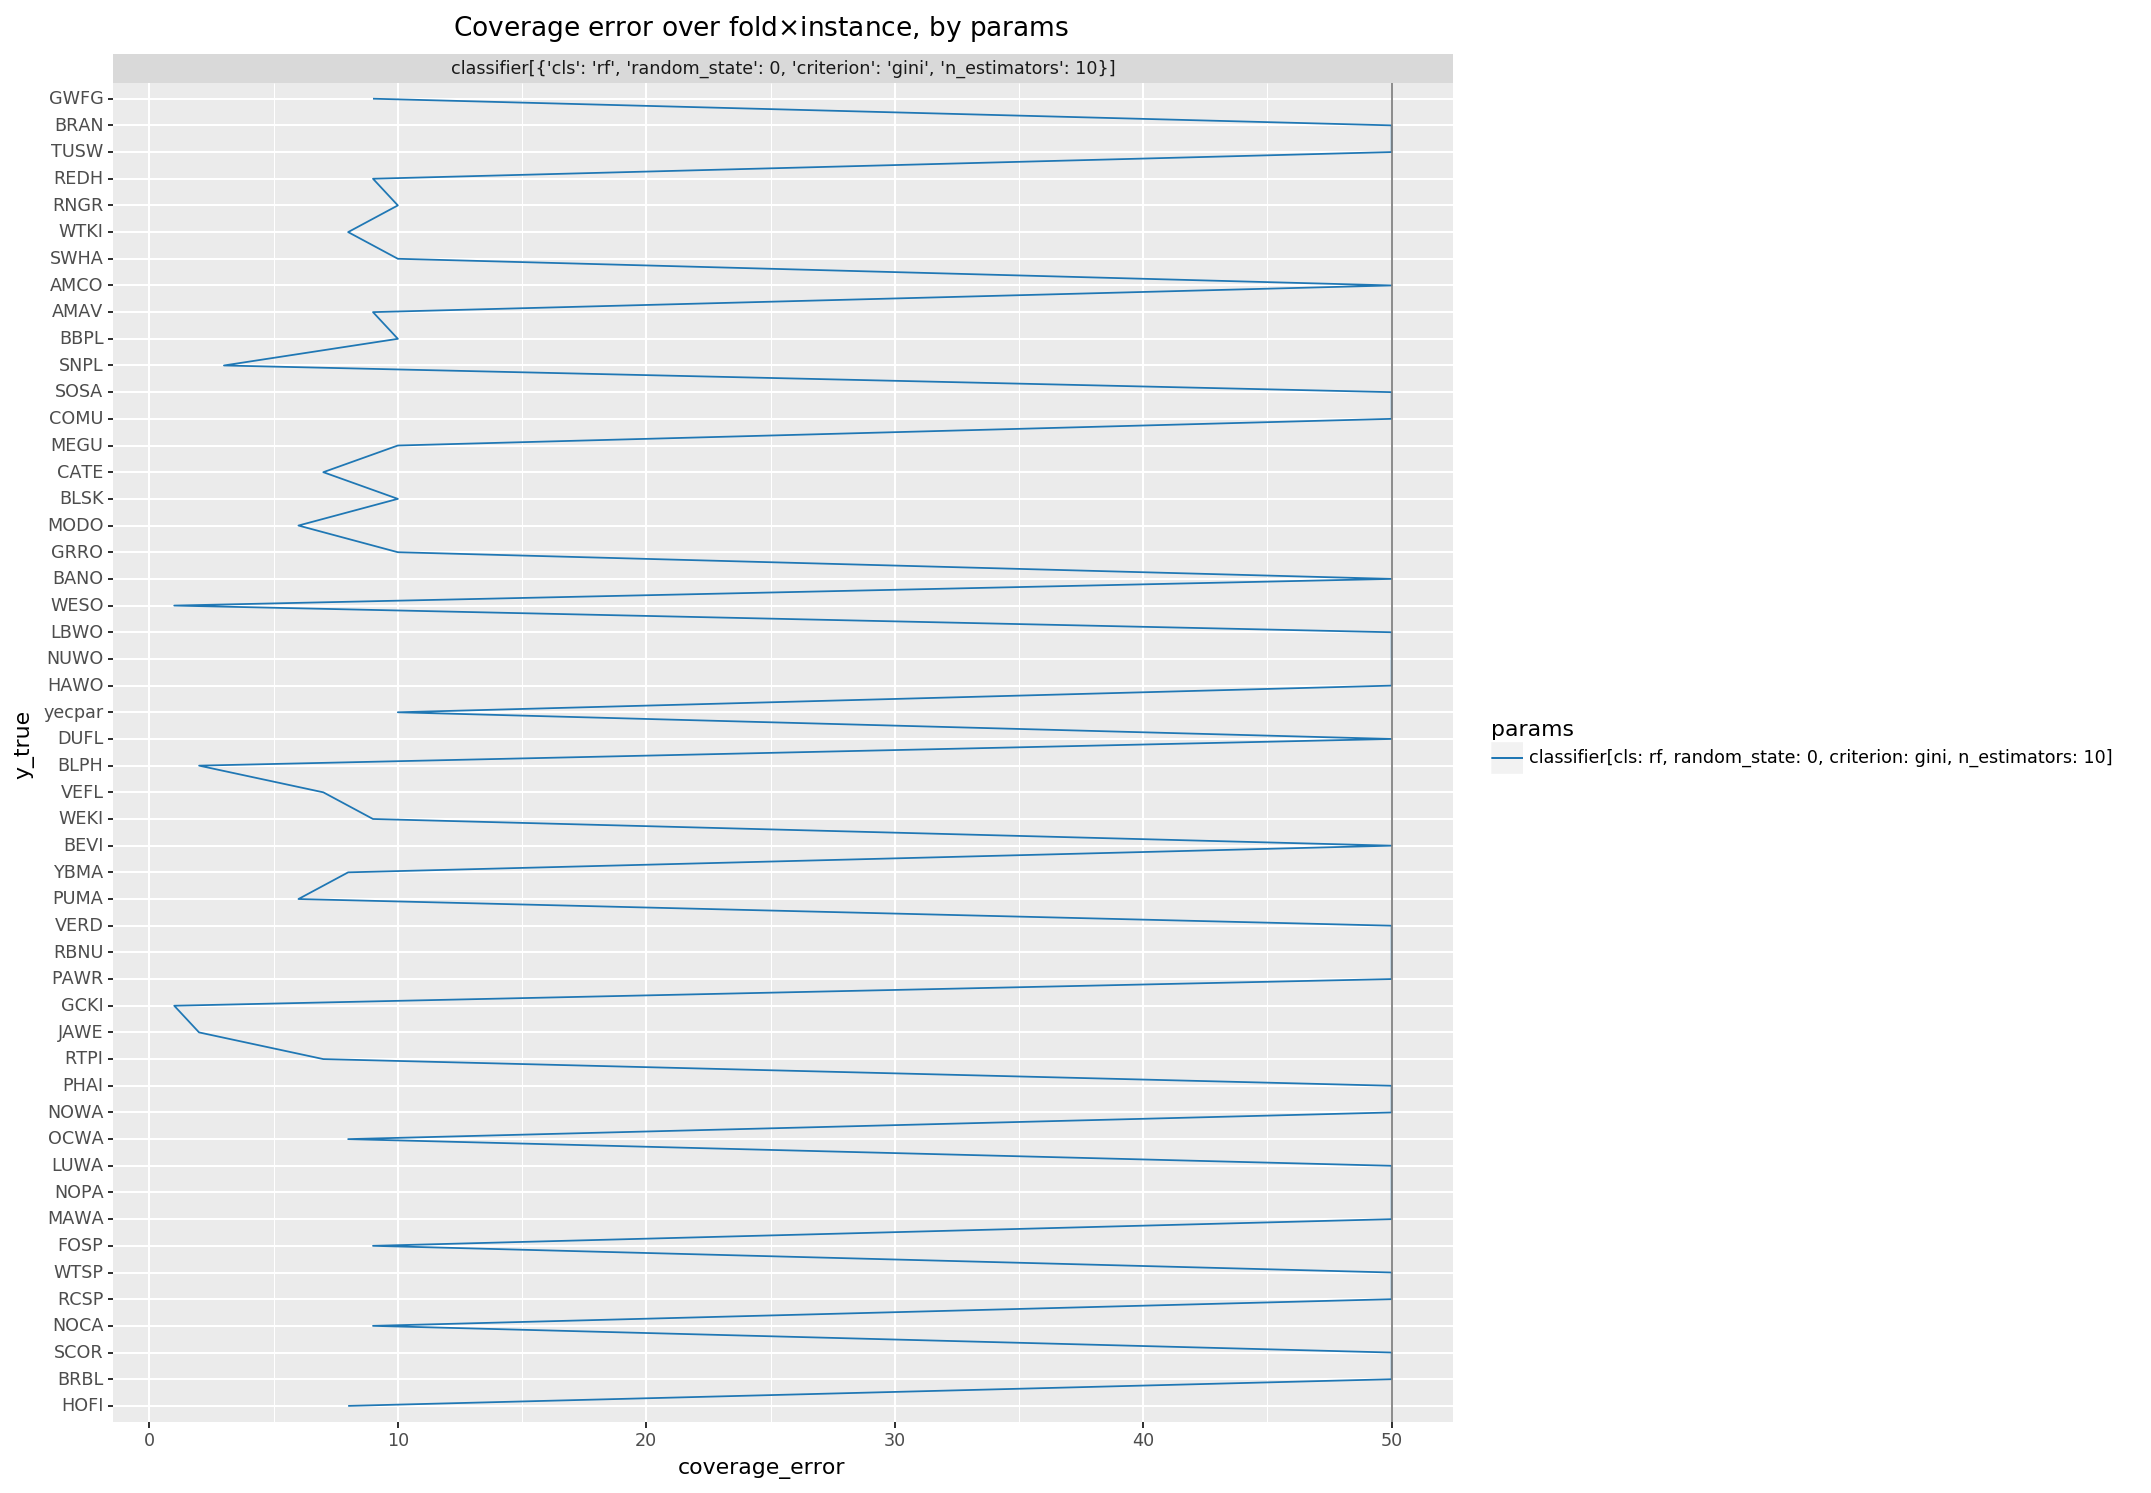

<ggplot: (311271502)>

In [ ]:
# Facet by classifier_type, order by median(coverage_error)
#   - Subset: all models
#   - Grain: sum(recs[model.test_i].groupby(params, y_true) for model)
#       - Over: fold, rec_id
#   - Dims: params, y_true
#   - Metrics: coverage_error.median
# in: coverage_errors_all_all, recs
(coverage_errors_all_all
    # Sort species by median(coverage_error) (across all models)
    .pipe(df_ordered_cat, y_true=lambda df: (
        # TODO Restore non-taxo sort after debug
        # df.groupby('y_true').agg({'coverage_error': np.median}).reset_index().sort_values('coverage_error').y_true
        reversed(recs.species.cat.categories)
    ))
    .pipe(ggplot, aes(x='y_true', y='coverage_error', color='params'))
    + facet_wrap('classifier_type')
    + geom_line(aes(group='params'), stat='summary', fun_y=np.median)
    + coord_flip(
        # ylim=(0, min(30, len(np.unique(y)))),  # TODO Restore after debug
    )
    + geom_hline(yintercept=recs.species.nunique(), color='grey')
    + scale_color_cmap_d(mpl.cm.tab20)
    + theme_figsize('square')
    # + theme_figsize('full')
    # + theme_figsize('full_dense')
    + ggtitle(rf'Coverage error over fold$\times$instance, by params')
)

In [ ]:
# TODO Slow, bad for notebook dev loop -- move lower, or disable by default?
# Facet by species
#   - Subset: all models
#   - Grain: sum(recs[model.test_i].groupby(params, y_true) for model)
#       - Over: fold, rec_id
#   - Dims: params, y_true
#   - Metrics: coverage_error.median
# in: coverage_errors_all_all, recs
(coverage_errors_all_all
    # .sample(200, random_state=0)  # Faster dev
    .astype({'y_true': metadata.species.df.shorthand.dtype})
    .pipe(df_ordered_cat, params=lambda df: reversed(param_list))
    .pipe(ggplot, aes(x='params', y='coverage_error', color='classifier_type'))
    + facet_wrap('y_true')
    + geom_hline(yintercept=1, color='grey')
    + geom_hline(yintercept=recs.species.nunique(), color='grey')

    # Percentiles (faster, no overplot)
    # + geom_point(stat='summary', fun_y=np.median)
    # + geom_linerange(stat='summary', fun_ymin=partial(np.percentile, q=25), fun_ymax=partial(np.percentile, q=75))

    # Violin (slow, no overplot)
    # + geom_violin()

    # Boxplot (very slow, no overplot)
    # + geom_boxplot()

    # Points (medium cost, high overplot)
    #   - n (count) instead of prop (proportion)
    #   - scale_size_area() instead of default scale_size(), because it's a count [I don't grok this but it looks good]
    + geom_count(aes(size='..n..'), alpha=.5)
    + scale_size_area()
    + geom_point(stat='summary', fun_y=np.median, alpha=1, color='black', shape='|', size=3, stroke=1)

    + coord_flip()
    + scale_color_cmap_d(mpl.cm.tab20)
    + theme(axis_text_y=element_text(size=6))
    + theme_figsize('square')  # Faster
    # + theme_figsize('half')
    # + theme_figsize('full')
    # + theme_figsize('full_dense')
    + ggtitle(rf'Coverage error over fold$\times$instance, by params')
)

[skip]

# Model diagnostics: one model, all folds

In [ ]:
params_i = -1
params = param_list[params_i]
print("param_list:\n%s" % '\n'.join('  %s: %r' % (i, x) for i, x in enumerate(param_list)))
print()
print('models:')
print('  params[%s/%s]: %r' % (params_i, len(param_list), params))
print('  fold[*/%s]' % cv.cv.n_splits)

param_list:
  0: 'classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10]'

models:
  params[-1/1]: 'classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10]'
  fold[*/1]


In [ ]:
# Coverage errors: one model, all folds
#   - Subset: models.params == params
#   - Grain: sum(recs[model.test_i] for model)
#   - Dims: model_id, params, fold, y_true, rec_id
#   - Metrics: coverage_error
coverage_errors_one_all = (coverage_errors_all_all
    [lambda df: df.params == params]  # One model, all folds
)
display(
    df_summary(coverage_errors_one_all).T,
    coverage_errors_one_all[:10],
)

,,,,,,,,min,25%,50%,75%,max
,dtype,sizeof,len,count,nunique,mean,std,,,,,
model_id,object,22650,50,50,1,NaN,NaN,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], fold[0]"
params,object,20400,50,50,1,NaN,NaN,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10]"
classifier_type,object,23900,50,50,1,NaN,NaN,"classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]"
fold,int64,1200,50,50,1,NaN,NaN,0,0,0,0,0
i,int64,1400,50,50,50,NaN,NaN,4,60,123,181,246
y_true,object,5260,50,50,50,NaN,NaN,AMAV,FOSP,NOCA,RTPI,yecpar
coverage_error,float64,1200,50,50,9,NaN,NaN,1,8,10,50,50


,model_id,params,classifier_type,fold,i,y_true,coverage_error
0,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]",0,18,REDH,9.0
1,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]",0,167,PAWR,50.0
2,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]",0,137,WEKI,9.0
3,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]",0,178,JAWE,2.0
4,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]",0,60,COMU,50.0
5,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]",0,10,TUSW,50.0
6,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]",0,148,YBMA,8.0
7,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]",0,85,GRRO,10.0
8,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]",0,193,NOWA,50.0
9,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]",0,123,DUFL,50.0


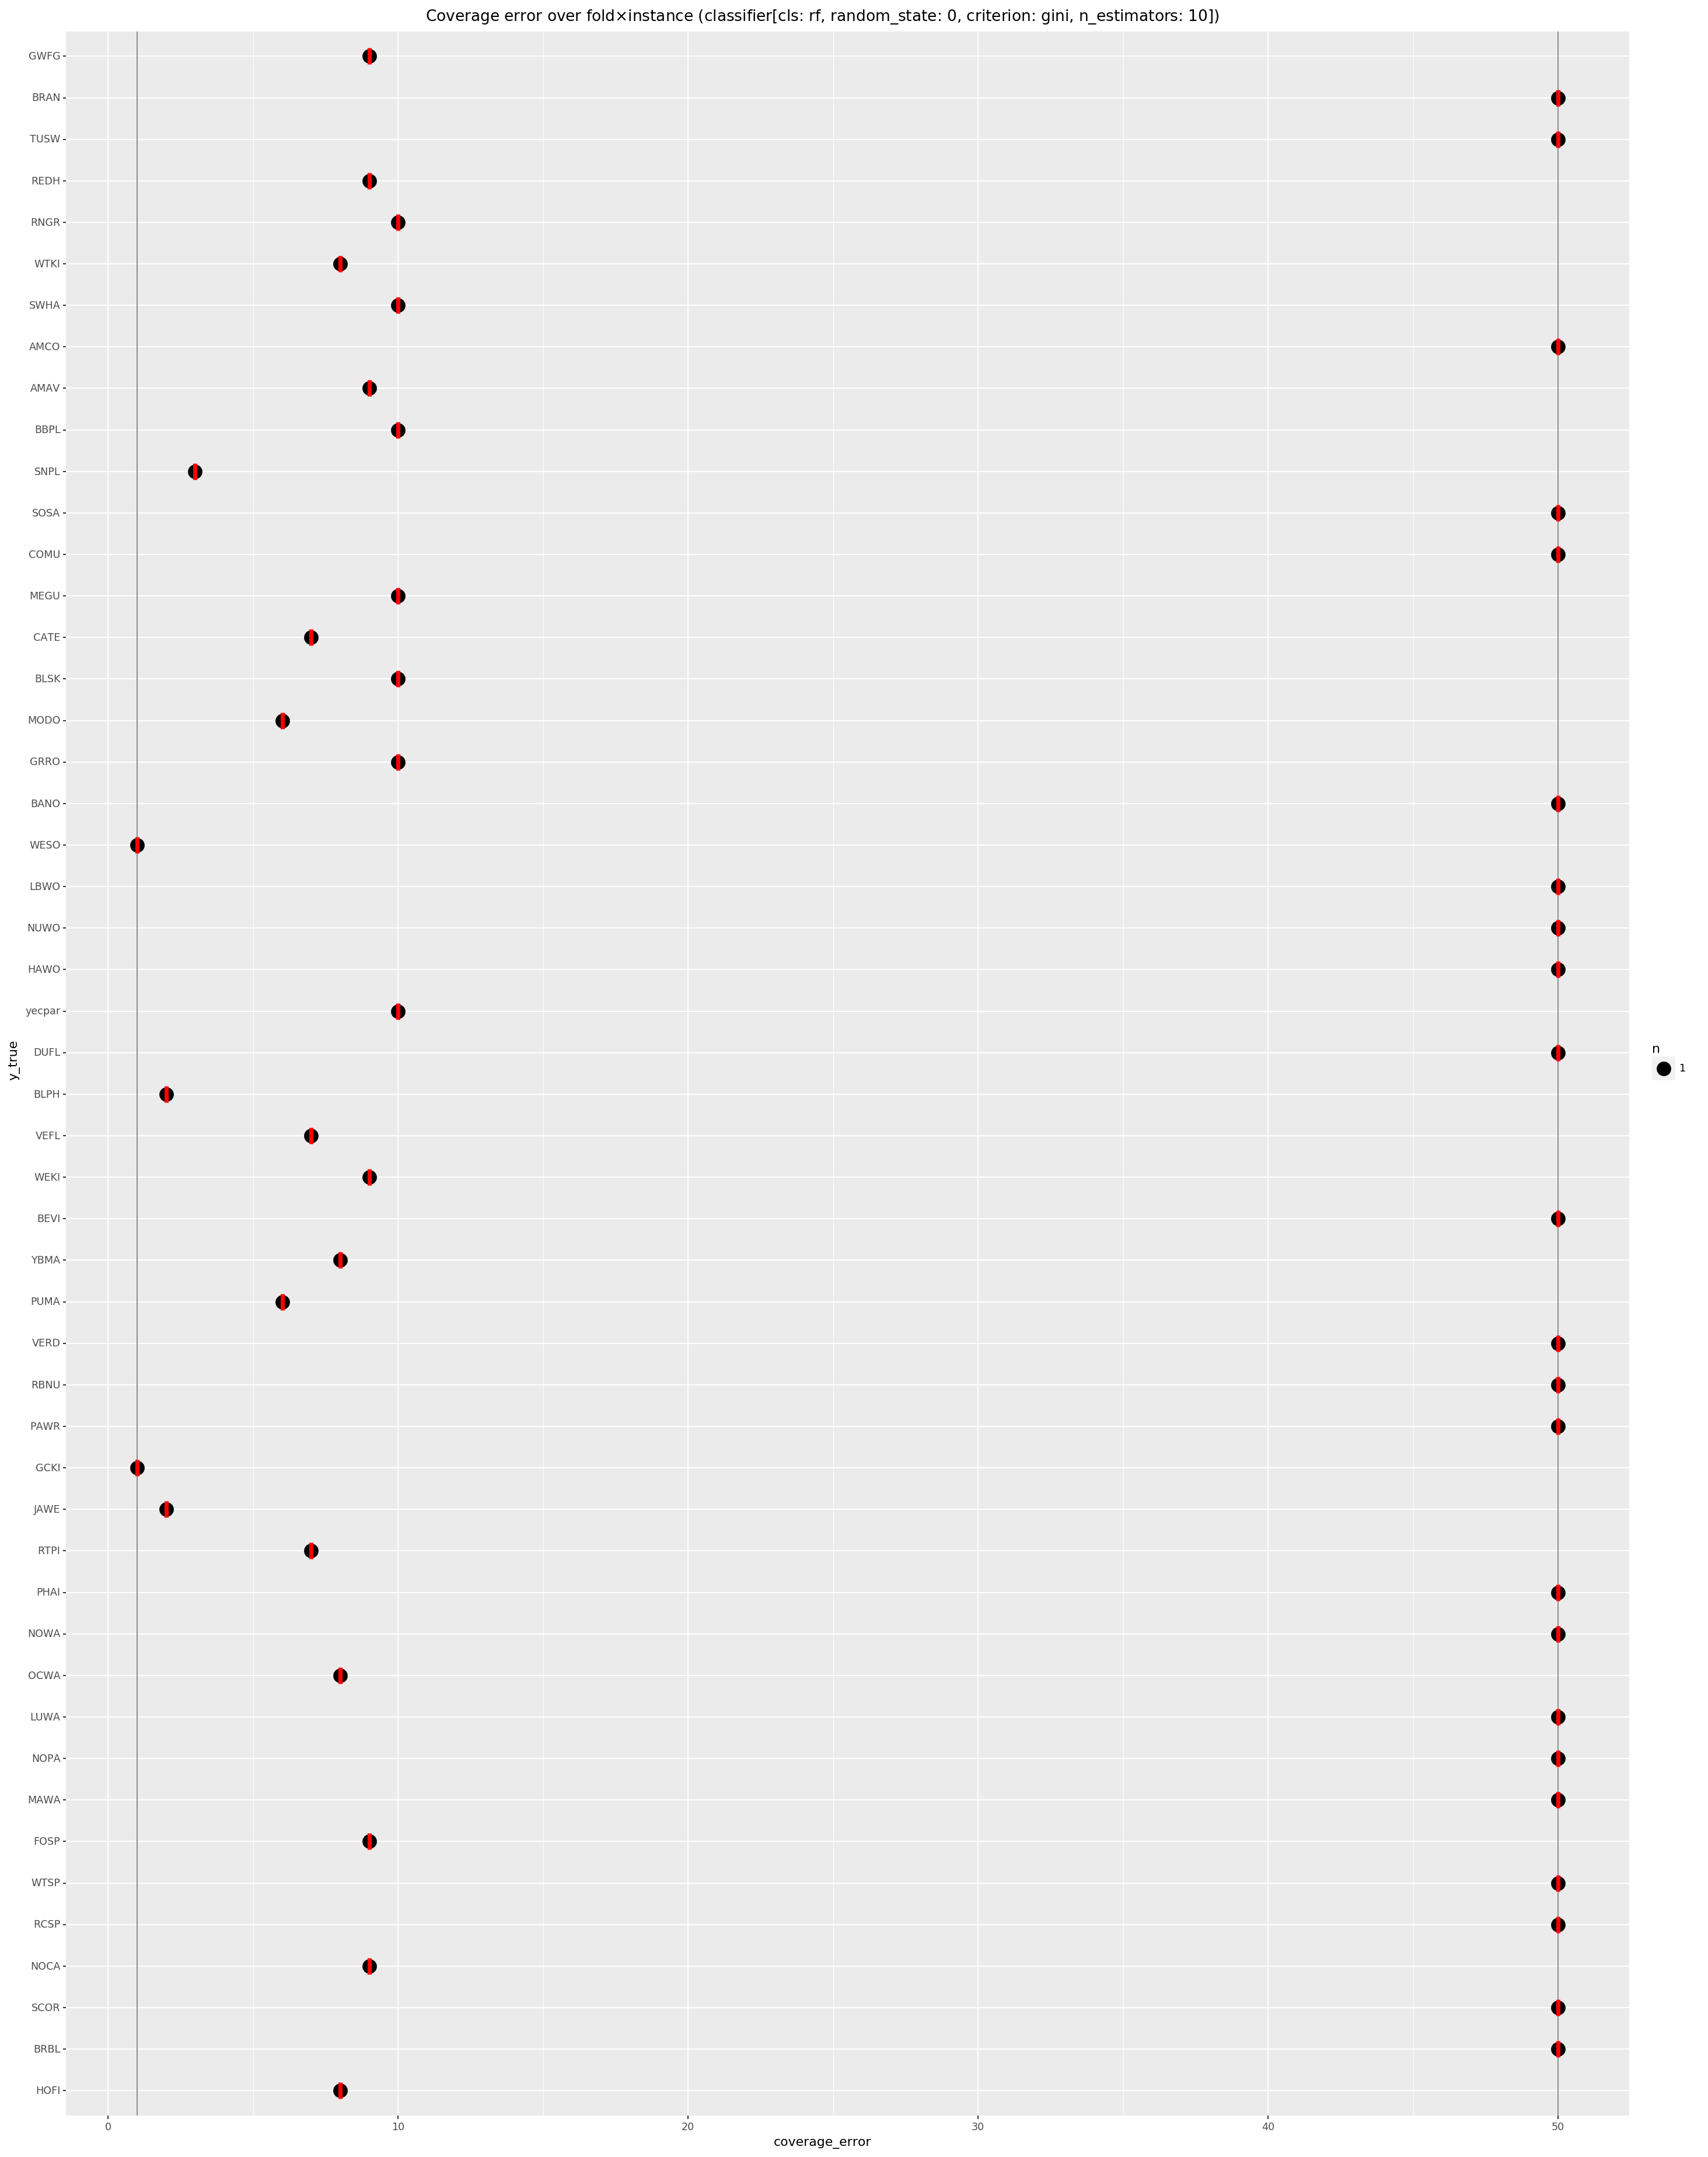

<ggplot: (314599218)>

In [ ]:
# NOTE Debug: That's funny, it looks like the dynamic range of coverage_error is [1,10]+[50]...
#   - Subset: models.params == params
#   - Grain: sum(recs[model.test_i].groupby(y_true) for model)
#       - Over: fold, rec_id
#   - Dims: y_true
#   - Metrics: count, coverage_error.percentiles
# in: coverage_errors_one_all, recs
(coverage_errors_one_all
    .astype({'y_true': metadata.species.df.shorthand.dtype})
    .pipe(df_reverse_cat, 'y_true')
    .pipe(ggplot, aes(x='y_true', y='coverage_error'))
    + geom_hline(yintercept=1, color='grey')
    + geom_hline(yintercept=recs.species.nunique(), color='grey')
    + geom_count(aes(size='..n..'), alpha=1)  # n (count) instead of prop (proportion)
    + scale_size_area()  # Instead of default scale_size(), because it's a count [I don't grok this but it looks good]
    + geom_point(stat='summary', fun_y=np.median, alpha=1, color='red', shape='|', size=6, stroke=2)
    + coord_flip()
    # + theme_figsize('inline')
    # + theme_figsize('square')
    # + theme_figsize('half')
    + theme_figsize('half_dense')
    # + theme_figsize('full')
    # + theme_figsize('full_dense')
    + ggtitle(rf'Coverage error over fold$\times$instance ({params})')
)

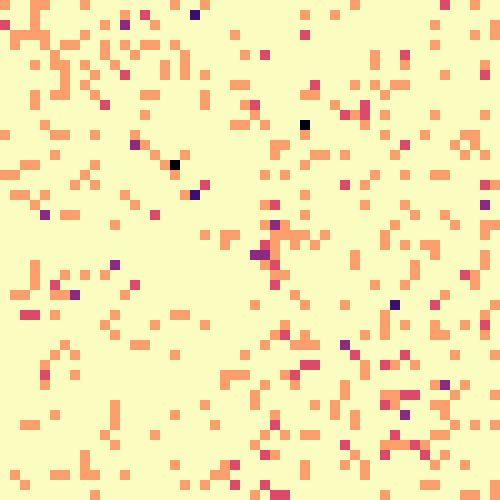

In [ ]:
# One-model/all-folds confusion matrix
with figsize(
    # 'square',
    # 'full',
    'full_dense',
):
    (cv_models
        [lambda df: df.params == params]
        .pipe(lambda df: plot_confusion_matrix(
            classes=df.iloc[0].test_evals.classes,
            M=np.array([
                row.test_evals.confusion_matrix_prob()
                for row in df_rows(df)
            ]).sum(axis=0),
            # normalize=False,  # For counts
            raw=True, scale=10,  # Faster dev
            format=None,  # Omit numbers, too dense
        ))
    )

# Model diagnostics: one model, one fold

In [ ]:
fold = 0
# params_i = ...  # Comment out to reuse from above
params = param_list[params_i]
[(_, model)] = list(cv_models[lambda df: (df.params == params) & (df.fold == fold)].iterrows())
print("param_list:\n%s" % '\n'.join('  %s: %r' % (i, x) for i, x in enumerate(param_list)))
print()
print('model:')
print('  params[%s/%s]: %r' % (params_i, len(param_list), model.params))
print('  fold[%s/%s]' % (model.fold, cv.cv.n_splits))
print()
print(model)

[skip]

In [ ]:
# in: model
model_id = model.model_id
params = model.params
fold = model.fold
# train_evals = model.train_evals
test_evals = model.test_evals

# in: model, recs
# train_recs = recs.iloc[train_evals.i]
# train_X = Search.X(recs)[train_evals.i]
# train_y = Search.y(recs)[train_evals.i]
test_recs = recs.iloc[test_evals.i]
test_X = Search.X(recs)[test_evals.i]
test_y = Search.y(recs)[test_evals.i]  # (Don't need to store cv_models.test_evals.y if we have recs -- which sometimes we don't?)

display(
    # len(train_recs),
    len(test_recs),
)

[skip]

In [ ]:
# TODO Restore this plot like 'Coverage error over ...' above, so we can see _one_ model instead of aggregating over n_splits models
# # TODO Update [kill the .merge, then species -> y_true]
# (search.coverage_error_by(test_recs, 'id')
#     [:5]
#     # .merge(test_recs[['id', 'species']], on='id', how='left')
#     # .pipe(ggplot, aes(x='species', y='coverage_error'))
#     # + geom_count(aes(size='..n..'))
#     # + stat_summary(fun_y=np.median, geom='point', color='red', alpha=.5, shape='|', size=6, stroke=1)
#     # + stat_summary(
#     #     fun_ymin=partial(np.percentile, q=25), fun_ymax=partial(np.percentile, q=75),
#     #     geom='linerange', color='red', alpha=.5, size=1,
#     # )
#     # + coord_flip()
#     # + geom_hline(yintercept=len(search.classes_), color='grey')
#     # + scale_x_discrete(limits=list(reversed(test_recs.species.cat.categories)))
#     # + theme_figsize('square')
#     # + ggtitle(rf'Coverage error over instance ({model_id})')
# )

[skip]

In [ ]:
# One-model/one-fold confusion matrix
with figsize(
    'square',
    # 'full',
    # 'full_dense',
):
    plot_confusion_matrix_df(
        confusion_matrix_prob_df(model.test_evals.y, model.test_evals.y_scores, model.test_evals.classes),
        title=model.model_id,
        # normalize=False,  # For counts
        raw=True, scale=10,  # Faster dev
    )

[skip]